In [22]:
import sys
sys.path.append('/home/599/dbi599/ocean-analysis/modules')

import iris
import iris.analysis.cartography
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

import convenient_universal as uconv
import timeseries

In [11]:
wfo_file = '/g/data/fs38/publications/CMIP6/FAFMIP/CSIRO-ARCCSS/ACCESS-CM2/faf-passiveheat/r1i1p1f1/Omon/wfo/gn/v20191210/wfo_Omon_ACCESS-CM2_faf-passiveheat_r1i1p1f1_gn_095001-101912.nc'

In [12]:
wfo_cube = iris.load_cube(wfo_file, 'water_flux_into_sea_water')
wfo_cube = uconv.flux_to_magnitude(wfo_cube)
wfo_cube = timeseries.convert_to_annual(wfo_cube, aggregation='sum')

/g/data/r87/dbi599/miniconda3/envs/ocean3/lib/python3.7/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'wfo'
  warnings.warn(message % (variable_name, nc_var_name))


In [19]:
projection = ccrs.PlateCarree()
new_cube, extent = iris.analysis.cartography.project(wfo_cube, projection, nx=400, ny=200)

/g/data/r87/dbi599/miniconda3/envs/ocean3/lib/python3.7/site-packages/iris/analysis/cartography.py:614: UserWarning: Coordinate system of latitude and longitude coordinates is not specified. Assuming WGS84 Geodetic.
  warnings.warn('Coordinate system of latitude and longitude '
/g/data/r87/dbi599/miniconda3/envs/ocean3/lib/python3.7/site-packages/iris/analysis/cartography.py:780: UserWarning: Discarding coordinates that share dimensions with latitude and longitude: ['cell index along first dimension', 'cell index along second dimension']
  coord in discarded_coords]))


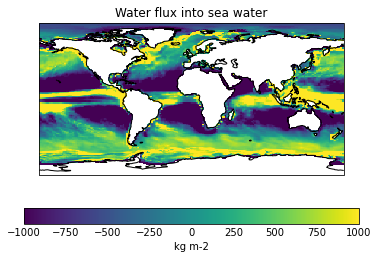

In [27]:
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.set_global()
qplt.pcolormesh(new_cube[0, ::], vmin=-1000, vmax=1000)
ax.coastlines()
iplt.show()

In [ ]:
wfo_cumsum_cube = wfo_cube[0, ::].copy()
wfo_cumsum_cube.data = np.cumsum(wfo_cube.data, axis=0)